In [1]:
import numpy as N
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
import analysis_tools_pd as tools_pd
%matplotlib inline
# My matplotlib style
plt.style.use('nuala')

## Define the paths to the data and figures

In [2]:
galform_datapath = '/gpfs/data/nmccull/emocks/galform/newmrg/'
galform_statspath = '/gpfs/data/nmccull/emocks/galform/galform_stats/newmrg/'
sham_datapath = '/gpfs/data/nmccull/emocks/abmatch/newmrg/'
sham_statspath = '/gpfs/data/nmccull/emocks/halo/halo_stats/newmrg/'
halo_datapath = '/gpfs/data/nmccull/emocks/halo/'
boot_datapath = '/gpfs/data/nmccull/emocks/bootstrap/'
lgals_datapath='/gpfs/data/nmccull/lgals/data/'
figurepath = 'figures/'

## Define constants for the simulations and analysis used throughout

In [60]:
# Box size of P-Millennium simulation
boxlen = 542.16
vol = boxlen**3
# Number of SHAM realizations
nsham = 10
# Number of spheres used in VPF calculation
nspheres = 100000
# Number of bootstrap samples used in HOD fitting
nbootstraps = 50
# Threshold for tapering the dust extinction
threshold = 2.0
# Colormap to use in 2D histograms
cmap = 'rainbow'
# Number densities for SDSS samples we are studying
sample_list = ['m1', 'm2', 'm3', 'm8']
nbar = {'m1': 5e-5, 'm2': 2.8e-4, 'm3': 1.16e-3, 'm8': 2.311e-2}
sample_labels={'m1':r'${\rm S1}: 5.0\times 10^{-5}$ (Mpc/$h$)$^{-3}$', 'm2':r'${\rm S2}: 2.8\times 10^{-4}$ (Mpc/$h$)$^{-3}$', \
               'm3':r'${\rm S3}: 1.2\times 10^{-3}$ (Mpc/$h$)$^{-3}$','m8':r'${\rm S8}: 2.3\times 10^{-2}$ (Mpc/$h$)$^{-3}$'}
mstar_sample_labels={'m1':r'${\rm S1}^*: 5.0\times 10^{-5}$ (Mpc/$h$)$^{-3}$', 'm2':r'${\rm S2}^*: 2.8\times 10^{-4}$ (Mpc/$h$)$^{-3}$', \
               'm3':r'${\rm S3}^*: 1.2\times 10^{-3}$ (Mpc/$h$)$^{-3}$', 'm8':r'${\rm S8}^*: 2.3\times 10^{-2}$ (Mpc/$h$)$^{-3}$'}

# Scatter used in SHAM for each sample to match large-scale clustering
sham_scatter = scatter={'m1':0.6, 'm2':0.8, 'm3':1.1, 'm8':1.2}

In [4]:
# Jenkins mass function for WMAP7 cosmology, used in the SDSS analysis
massfunction_wmap7 = N.loadtxt('/gpfs/data/nmccull/emocks/hmf/mvector_z0.1.txt')
# Halo mass bins to use for HODs, etc
halo_mass_bins = N.concatenate([N.logspace(10.0, 14., 80), N.logspace(14.0506, 15.8, 8)])
# Bin centers
mh = (halo_mass_bins[1:]+halo_mass_bins[:-1])/2
# SDSS HODs from Zehavi 2011
hod_sdss_lowsigmaM = tools_pd.compute_hod_model(mh, tools_pd.hod_params_sdss_lowsigmaM)
hod_sdss = tools_pd.compute_hod_model(mh, tools_pd.hod_params_sdss)
# Interpolated mass function and halo bias from halo model using Jenkins WMAP7 mass function
dndlogM, halo_bias = tools_pd.get_massfn_bias(massfunction_wmap7)

## Load in the Galform galaxy catalogue

In [5]:
# r-band magnitude with dust extinction
magr_dust=N.load(galform_datapath+'galform_magr.npy')
# total r-band magnitude before dust extinction
magr_nodust=N.load(galform_datapath+'galform_magr_tot.npy')
# g-band magnitude with dust extinction
magg_dust=N.load(galform_datapath+'galform_magg_tot_ext.npy')
# total g-band magnitude before dust extinction
magg_nodust=N.load(galform_datapath+'galform_magg_tot.npy')
# stellar mass
mstar=N.load(galform_datapath+'galform_mstar.npy')
# vpeak from subhalo merger trees
vpeak=N.load(galform_datapath+'galform_vpeak.npy')
# Read in DHalo mass and central / satellite for Galform galaxies
mhalo=N.load(galform_datapath+'mhhalo.npy')
central=N.load(galform_datapath+'central.npy')
# Put the Galform data in a pandas DataFrame
galform_data_all = pd.DataFrame({'Mr dust': magr_dust, 'Mr no dust': magr_nodust, \
                                 'Mg dust': magg_dust, 'Mg no dust': magg_nodust, 'Mstar': mstar, 'Vpeak': vpeak, \
                                 'mhhalo': mhalo, 'galaxy type': central})
galform_data_all.loc[galform_data_all['galaxy type']==1, 'galaxy type']='central'
galform_data_all.loc[galform_data_all['galaxy type']==0, 'galaxy type']='satellite'

In [6]:
# Compute r- and g-band magnitudes with extinction tapered to some threshold value
galform_data_all = tools_pd.taper_magr_magg(galform_data_all, threshold)
# Add columns for whether a galaxy is red or blue
galform_data_all = tools_pd.add_color(galform_data_all)
# Map halo masses to the WMAP7 mass function used in SDSS
galform_data_all = tools_pd.map_halo_mass(galform_data_all, massfunction_wmap7)

## Define Galform samples and compute HODs

In [7]:
# define Mr and stellar mass cuts for SDSS samples
magr_sort = galform_data_all['Mr tapered'].sort_values()
mstar_sort = galform_data_all['Mstar'].sort_values(ascending=False)
mr_cut_galform = {}
mstar_cut_galform = {}
for sample in sample_list:
    ngal = N.int(vol*nbar[sample])
    mr_cut_galform[sample] = magr_sort.iloc[ngal]
    column_name = 'in sample '+sample
    galform_data_all[column_name] = False
    galform_data_all.loc[galform_data_all['Mr tapered']<mr_cut_galform[sample], column_name] = True
    mstar_cut_galform[sample] = mstar_sort.iloc[ngal]
    column_name = 'in mstar sample '+sample
    galform_data_all[column_name] = False
    galform_data_all.loc[galform_data_all['Mstar']>mstar_cut_galform[sample], column_name] = True

In [8]:
galform_hod = pd.DataFrame({'Mh': mh})
galform_hod['halo mass fn'] = galform_data_all.groupby('galaxy type')['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)['central'][0].astype(N.float)
for sample in sample_list:
    hod_all = galform_data_all.groupby('in sample '+sample)['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    galform_hod[sample + ' all'] = hod_all[True][0].astype(N.float) / galform_hod['halo mass fn']
    hod_type = galform_data_all.groupby(['in sample '+sample, 'galaxy type'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    galform_hod[sample + ' central'] = hod_type[(True, 'central')][0].astype(N.float) / galform_hod['halo mass fn']
    galform_hod[sample + ' satellite'] = hod_type[(True, 'satellite')][0].astype(N.float) / galform_hod['halo mass fn']
    hod_color = galform_data_all.groupby(['in sample '+sample, 'color'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    galform_hod[sample + ' red'] = hod_color[(True, 'red')][0].astype(N.float) / galform_hod['halo mass fn']
    galform_hod[sample + ' blue'] = hod_color[(True, 'blue')][0].astype(N.float) / galform_hod['halo mass fn']
    hod_all = galform_data_all.groupby('in mstar sample '+sample)['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    galform_hod[sample + ' all mstar'] = hod_all[True][0].astype(N.float) / galform_hod['halo mass fn']
    hod_type = galform_data_all.groupby(['in mstar sample '+sample, 'galaxy type'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    galform_hod[sample + ' central mstar'] = hod_type[(True, 'central')][0].astype(N.float) / galform_hod['halo mass fn']
    galform_hod[sample + ' satellite mstar'] = hod_type[(True, 'satellite')][0].astype(N.float) / galform_hod['halo mass fn']    

## Load in Galform clustering data (projected correlation function + VPF)

In [11]:
# read in galform correlation functions
galform_clustering_data = pd.DataFrame()

for sample in sample_list:
    cf=N.loadtxt(galform_statspath+'xi_%s_dust_t%1.1f.txt'%(sample, threshold))
    rp, wp = tools_pd.compute_wp_box(cf[:,0], cf[:,1])
    galform_clustering_data['wp '+sample] = wp
galform_clustering_data['rp'] = rp

In [12]:
# Void probability functions
vpf_galform = pd.DataFrame()

for sample in sample_list:
    vpf_out=N.loadtxt(galform_statspath+'vpf_galform_'+sample+'_n%i_0.txt'%nspheres)
    vpf_galform['vpf real '+sample] = vpf_out[:,1]
    vpf_galform['r '+sample] = vpf_out[:,0]
    vpf_out=N.loadtxt(galform_statspath+'vpf_galform_'+sample+'_n%i_0_rs.txt'%nspheres)
    vpf_galform['vpf redshift '+sample] = vpf_out[:,1]  

## Load in SHAM data

In [14]:
# Read in SHAM data: vpeak of subhaloes and Mr for each of the samples (different scatters used)
vpeak_halo=N.load(halo_datapath+'halo_vpeak_all.npy')
sham_data_all = pd.DataFrame({'Vpeak': vpeak_halo})

for sample in sample_list:
    magr_sham = N.load(sham_datapath+'abmatch_magr_ext%1.1f_sc%1.1f.npy'%(threshold, sham_scatter[sample]))
    sham_data_all['Mr '+sample]=magr_sham
    
    
# Load in the mass and centrals for SHAM subhalos
mhalo_sham=N.load(halo_datapath+'host_mass.npy')
centrals_sham = N.load(halo_datapath+'central.npy')
sham_data_all['mhhalo'] = mhalo_sham
sham_data_all['galaxy type'] = centrals_sham
sham_data_all.loc[sham_data_all['galaxy type']==1, 'galaxy type']='central'
sham_data_all.loc[sham_data_all['galaxy type']==0, 'galaxy type']='satellite'
# Map halo masses to the WMAP7 mass function used in SDSS
sham_data_all = tools_pd.map_halo_mass(sham_data_all, massfunction_wmap7)

for sample in sample_list:
    column_name = 'in sample '+sample
    sham_data_all[column_name] = False
    sham_data_all.loc[sham_data_all['Mr '+sample]<mr_cut_galform[sample], column_name] = True

sham_hod = pd.DataFrame({'Mh': mh})
sham_hod['halo mass fn'] = sham_data_all.groupby('galaxy type')['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)['central'][0].astype(N.float)
for sample in sample_list:
    hod_all = sham_data_all.groupby('in sample '+sample)['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    sham_hod[sample + ' all'] = hod_all[True][0].astype(N.float) / sham_hod['halo mass fn']


In [15]:
# Number of SHAM realizations
nsham = 10
sham_clustering_data = pd.DataFrame()
for sample in sample_list:
    cf_all = N.array([], dtype=N.float)
    rp_all = N.array([], dtype=N.float)
    for sham_index in N.arange(nsham):
        cf = N.loadtxt(sham_statspath+'xi_SHAM_%s_dust_t%1.1f_sc%1.1f_i%i.txt'%(sample, threshold, sham_scatter[sample], sham_index))
        rp, wp = tools_pd.compute_wp_box(cf[:,0], cf[:,1])
        cf_all = N.concatenate([cf_all, wp])
        rp_all = N.concatenate([rp_all, rp])
    sham_clustering_data['wp '+sample] = cf_all
sham_clustering_data['rp'] = rp_all

In [16]:
vpf_sham = pd.DataFrame()

for sample in sample_list:
    r_all = N.array([], dtype=N.float)
    vpf_sham_all = N.array([], dtype=N.float)
    vpf_ratio_all = N.array([], dtype=N.float)
    vpf_sham_all_rs = N.array([], dtype=N.float)
    vpf_ratio_all_rs = N.array([], dtype=N.float)
    
    for sham_index in N.arange(nsham):
        filename = sham_statspath+'vpf_SHAM_'+sample+'_sc%1.1f_n%i_0_i%i.txt'%(sham_scatter[sample], nspheres, sham_index)
        vpf_out = N.loadtxt(filename)
        vpf_sham_all = N.concatenate([vpf_sham_all, vpf_out[:,1]])
        vpf_ratio_all = N.concatenate([vpf_ratio_all, vpf_galform['vpf real '+sample]/vpf_out[:,1]])
        r_all = N.concatenate([r_all, vpf_out[:,0]])
        filename = sham_statspath+'vpf_SHAM_'+sample+'_sc%1.1f_n%i_0_i%i_rs.txt'%(sham_scatter[sample], nspheres, sham_index)
        vpf_out = N.loadtxt(filename)
        vpf_sham_all_rs = N.concatenate([vpf_sham_all_rs, vpf_out[:,1]])
        vpf_ratio_all_rs = N.concatenate([vpf_ratio_all_rs, vpf_galform['vpf redshift '+sample]/vpf_out[:,1]])
        
        
        
    vpf_sham['vpf real '+sample] = vpf_sham_all
    vpf_sham['ratio real '+sample] = vpf_ratio_all
    vpf_sham['vpf redshift '+sample] = vpf_sham_all_rs
    vpf_sham['ratio redshift '+sample] = vpf_ratio_all_rs
    vpf_sham['r '+sample] = r_all


## Load in bestfit HODs from bootstrap samples

In [17]:
galform_hod_boot = tools_pd.read_bootstrap_hods(boot_datapath+'galform', nbootstraps)
sham_hod_boot = tools_pd.read_bootstrap_hods(boot_datapath+'SHAM', nbootstraps)
success, bestfit_params_galform, galform_hod_bestfit = tools_pd.fit_HOD_params(galform_hod_boot['mh'].unique(), galform_hod_boot.groupby('mh').mean(), nbar, massfunction_wmap7, lowsigmaM=False)
success, bestfit_params_SHAM, sham_hod_bestfit = tools_pd.fit_HOD_params(sham_hod_boot['mh'].unique(), sham_hod_boot.groupby('mh').mean(), nbar, massfunction_wmap7, lowsigmaM=False)

## Load in L-Galaxies data, make samples and compute HODs

In [18]:
lgals_mstar = N.load(lgals_datapath+'mstar.npy')
lgals_centralM = N.load(lgals_datapath+'centralM.npy')
lgals_gtype = N.load(lgals_datapath+'gtype.npy')
lgals_rdust = N.load(lgals_datapath+'rdust.npy')
lgals_gdust = N.load(lgals_datapath+'gdust.npy')

lgals_data_all = pd.DataFrame({'Mr tapered': lgals_rdust, \
                                 'Mg tapered': lgals_gdust, 'Mstar': lgals_mstar, \
                                 'mhhalo': lgals_centralM, 'galaxy type': lgals_gtype})

lgals_data_all.loc[lgals_data_all['galaxy type']!=0, 'galaxy type']='satellite'
lgals_data_all.loc[lgals_data_all['galaxy type']==0, 'galaxy type']='central'

# Add columns for whether a galaxy is red or blue
lgals_data_all = tools_pd.add_color(lgals_data_all, cutA = 0.6, cutB = -0.03)
# Map halo masses to the WMAP7 mass function used in SDSS
lgals_data_all = tools_pd.map_halo_mass(lgals_data_all, massfunction_wmap7)

In [19]:
magr_sort_lgals = lgals_data_all['Mr tapered'].sort_values()
mcut_lgals = {}
mstar_sort_lgals = lgals_data_all['Mstar'].sort_values(ascending=False)
mstar_cut_lgals = {}
for sample in sample_list:
    ngal = N.int(vol*nbar[sample])
    mcut_lgals[sample] = magr_sort.iloc[ngal]
    column_name = 'in sample '+sample
    lgals_data_all[column_name] = False
    lgals_data_all.loc[lgals_data_all['Mr tapered']<mcut_lgals[sample], column_name] = True
    ngal = N.int(vol*nbar[sample])
    mstar_cut_lgals[sample] = mstar_sort_lgals.iloc[ngal]
    column_name = 'in mstar sample '+sample
    lgals_data_all[column_name] = False
    lgals_data_all.loc[lgals_data_all['Mstar']>mstar_cut_lgals[sample], column_name] = True
    
lgals_hod = pd.DataFrame({'Mh': mh})
lgals_hod['halo mass fn'] = lgals_data_all.groupby('galaxy type')['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)['central'][0].astype(N.float)

for sample in sample_list:
    hod_all = lgals_data_all.groupby('in sample '+sample)['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    lgals_hod[sample + ' all'] = hod_all[True][0].astype(N.float) / lgals_hod['halo mass fn']
    hod_type = lgals_data_all.groupby(['in sample '+sample, 'galaxy type'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    lgals_hod[sample + ' central'] = hod_type[(True, 'central')][0].astype(N.float) / lgals_hod['halo mass fn']
    lgals_hod[sample + ' satellite'] = hod_type[(True, 'satellite')][0].astype(N.float) / lgals_hod['halo mass fn']
    hod_color = lgals_data_all.groupby(['in sample '+sample, 'color'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    lgals_hod[sample + ' red'] = hod_color[(True, 'red')][0].astype(N.float) / lgals_hod['halo mass fn']
    lgals_hod[sample + ' blue'] = hod_color[(True, 'blue')][0].astype(N.float) / lgals_hod['halo mass fn']        
    hod_all = lgals_data_all.groupby('in mstar sample '+sample)['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    lgals_hod[sample + ' all mstar'] = hod_all[True][0].astype(N.float) / lgals_hod['halo mass fn']
    hod_type = lgals_data_all.groupby(['in mstar sample '+sample, 'galaxy type'])['mhhalo wmap7'].aggregate(N.histogram, halo_mass_bins)
    lgals_hod[sample + ' central mstar'] = hod_type[(True, 'central')][0].astype(N.float) / lgals_hod['halo mass fn']
    lgals_hod[sample + ' satellite mstar'] = hod_type[(True, 'satellite')][0].astype(N.float) / lgals_hod['halo mass fn']
    

## Load in clustering data from shuffled Galform and SHAM samples

In [22]:
galform_shuffled_wp = pd.DataFrame()
sham_shuffled_wp = pd.DataFrame()

nsham=10
nshuffle_galform=10

for sample in sample_list:
    r_all = N.array([], dtype=N.float)
    wp_all = N.array([], dtype=N.float)
    for gal_index in N.arange(nshuffle_galform):
        cf=N.loadtxt(galform_datapath+'shuffle/xi_'+sample+'_%i.txt'%gal_index)
        r=cf[:,0]
        rpg, wpg=tools_pd.compute_wp_box(r, cf[:,1])
        
        r_all = N.concatenate([r_all, rpg])
        wp_all = N.concatenate([wp_all, wpg])
        
    galform_shuffled_wp['r'] = r_all
    galform_shuffled_wp['wp '+sample] = wp_all
    r_all = N.array([], dtype=N.float)
    wp_all = N.array([], dtype=N.float)
    
    for sham_index in N.arange(nsham):
        cf=N.loadtxt(halo_datapath+'shuffle/xi_SHAM_'+sample+'_sc%1.1f_i%i_0.txt'%(sham_scatter[sample], \
                                                                                        sham_index))
        rps, wps=tools_pd.compute_wp_box(cf[:,0], cf[:,1])
        r_all = N.concatenate([r_all, rps])
        wp_all = N.concatenate([wp_all, wps])
    sham_shuffled_wp['r'] = r_all
    sham_shuffled_wp['wp '+sample] = wp_all

In [74]:
galform_vpf_shuffled = pd.DataFrame()
sham_vpf_shuffled = pd.DataFrame()
ratio_vpf_shuffled = pd.DataFrame()

for sample in sample_list:
    r_all = N.array([], dtype=N.float)
    vpf_all = N.array([], dtype=N.float)
    vpf_ratio_all = N.array([], dtype=N.float)
    
    for gal_index in N.arange(nshuffle_galform):
        vpf_gal_data=N.loadtxt(galform_datapath+'shuffle/vpf_'+sample+'_%i_n%i_0.txt'%(gal_index, nspheres))
        vpf_all = N.concatenate([vpf_all, vpf_gal_data[:,1]])
        for sham_index in N.arange(nsham):
            vpf_sham_data = N.loadtxt(halo_datapath+'shuffle/vpf_'+sample+'_sc%1.1f_i%i_0_n%i_0.txt'%(sham_scatter[sample], \
                                                                                                      sham_index, nspheres))
            vpf_ratio_all = N.concatenate([vpf_ratio_all, vpf_gal_data[:,1] / vpf_sham_data[:,1]])
            r_all = N.concatenate([r_all, vpf_sham_data[:,0]])
        
    
    galform_vpf_shuffled['vpf '+sample] = vpf_all
    ratio_vpf_shuffled['ratio '+sample] = vpf_ratio_all
    ratio_vpf_shuffled['r '+sample] = r_all

    r_all = N.array([], dtype=N.float)
    vpf_all = N.array([], dtype=N.float)
    for sham_index in N.arange(nsham):
        vpf_sham_data = N.loadtxt(halo_datapath+'shuffle/vpf_'+sample+'_sc%1.1f_i%i_0_n%i_0.txt'%(sham_scatter[sample], \
                                                                                             sham_index, nspheres))
        r_all = N.concatenate([r_all, vpf_sham_data[:,0]])
        vpf_all = N.concatenate([vpf_all, vpf_sham_data[:,1]])
        
    sham_vpf_shuffled['r '+sample] = r_all
    galform_vpf_shuffled['r '+sample] = r_all
    sham_vpf_shuffled['vpf '+sample] = vpf_all

## Figure 1: Stellar mass vs r-band magnitude with and without extinction tapering

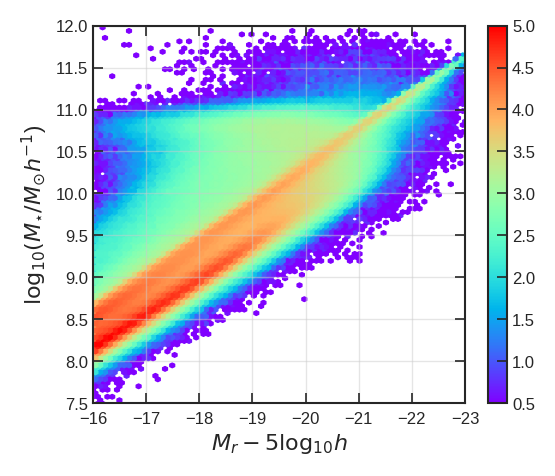

In [8]:
gridsize = 100
plt.figure(figsize=(6, 5))
subset = galform_data_all['Mr dust']<-16
plt.hexbin(galform_data_all.loc[subset, 'Mr dust'], N.log10(galform_data_all.loc[subset, 'Mstar']), \
           gridsize=gridsize, bins='log', cmap=cmap, mincnt=1, vmin=0.5, vmax=5.0)
plt.colorbar()
plt.xlabel(r'$M_r-5\log_{10}h$')
plt.ylabel(r'$\log_{10} (M_{\star}/M_{\odot}h^{-1}$)')
plt.xlim([-16, -23])
plt.ylim([7.5, 12])
plt.savefig(figurepath+'mstar_magr_fulldust.pdf')

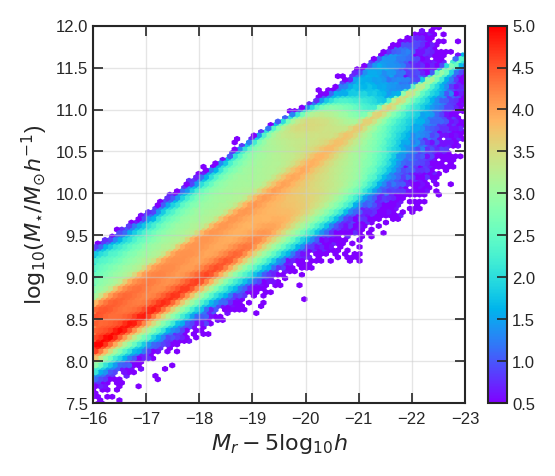

In [9]:
gridsize = 100
subset = galform_data_all['Mr tapered']<-16
plt.figure(figsize=(6, 5))
plt.hexbin(galform_data_all.loc[subset, 'Mr tapered'], N.log10(galform_data_all.loc[subset, 'Mstar']), \
           gridsize=gridsize, bins='log', cmap=cmap, mincnt=1, vmin=0.5, vmax=5.0)
plt.colorbar()
plt.xlabel(r'$M_r-5\log_{10}h$')
plt.ylabel(r'$\log_{10} (M_{\star}/M_{\odot}h^{-1}$)')
plt.xlim([-16, -23])
plt.ylim([7.5, 12])
plt.savefig(figurepath+'mstar_magr_tapered.pdf')

## Figure 2: Colour-magnitude diagram of Galform galaxies with tapered dust

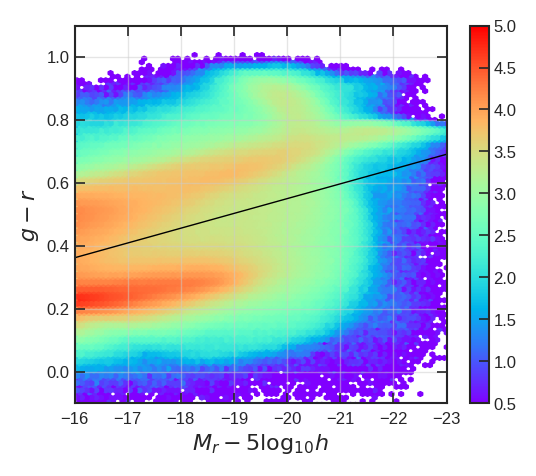

In [10]:
gridsize = 100
subset = galform_data_all['Mr tapered']<-16
plt.figure(figsize=(6, 5))
plt.hexbin(galform_data_all.loc[subset, 'Mr tapered'], \
           galform_data_all.loc[subset, 'Mg tapered']-galform_data_all.loc[subset, 'Mr tapered'], \
           gridsize=gridsize, bins='log', cmap=cmap, mincnt=1, vmin=0.5, vmax=5.0)

plt.colorbar()
# Colour cut line
mr=N.arange(-23, -15, 0.1)
cut=-0.047*(mr+20)+0.55
plt.plot(mr, cut, 'k', lw=1)
plt.xlim([-16, -23])
plt.ylim([-0.1, 1.1])
plt.xlabel(r'$M_r-5\log_{10}h$')
plt.ylabel(r'$g-r$')
plt.savefig(figurepath+'colormag_diagram.pdf')

## Figure 3: vpeak vs magnitude in Galform and SHAM

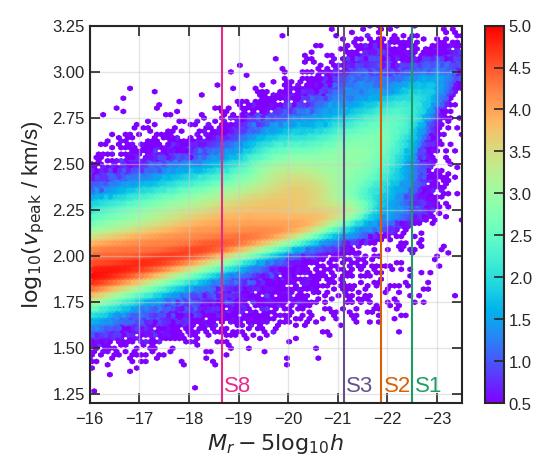

In [23]:
subset = (galform_data_all['Mr tapered']<-16)
gridsize=100
plt.figure(figsize=(6, 5))
plt.hexbin(galform_data_all.loc[subset, 'Mr tapered'], N.log10(galform_data_all.loc[subset, 'Vpeak']), bins='log', \
           mincnt=1, gridsize=gridsize, vmin=0.5, vmax=5.0)
plt.colorbar()
sample_text = {'m1':'S1', 'm2': 'S2', 'm3': 'S3', 'm8': 'S8'}

plt.xlabel(r'$M_r-5\log_{10}h$')
plt.ylabel(r'$\log_{10} (v_{\rm{peak}}$ / km/s)')

plt.xlim([-16, -23.5])
plt.ylim([1.2, 3.25])
plt.xticks([-16, -17, -18, -19, -20, -21, -22, -23])
for sample in sample_list:    
    line,=plt.plot([mr_cut_galform[sample], mr_cut_galform[sample]], [1.0, 3.5])
    plt.text(mr_cut_galform[sample]-0.05, 1.26, sample_text[sample], fontsize=16, color=line.get_color())

plt.savefig(figurepath+'vpeak_magr_galform_true.pdf')

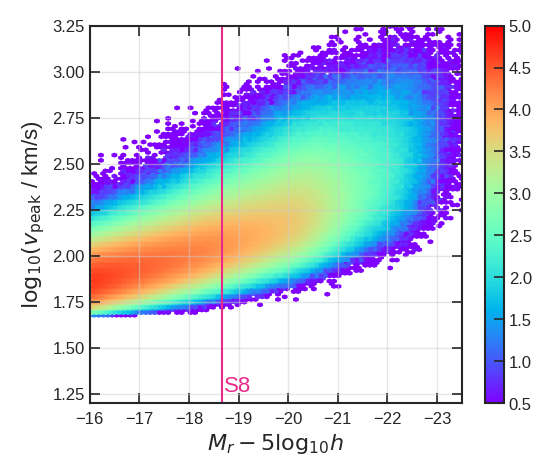

In [24]:
sham_sample='m8'
subset = (sham_data_all['Mr '+sham_sample]<-16)
gridsize=100
plt.figure(figsize=(6, 5))
plt.hexbin(sham_data_all.loc[subset, 'Mr '+sham_sample], N.log10(sham_data_all.loc[subset, 'Vpeak']), \
           bins='log', mincnt=1, gridsize=gridsize, vmin=0.5, vmax=5.0)
plt.colorbar()

plt.xlabel(r'$M_r-5\log_{10}h$')
plt.ylabel(r'$\log_{10} (v_{\rm{peak}}$ / km/s)')

plt.xlim([-16, -23.5])
plt.ylim([1.2, 3.25])
plt.xticks([-16, -17, -18, -19, -20, -21, -22, -23])

plt.plot([mr_cut_galform[sham_sample], mr_cut_galform[sham_sample]], [1.0, 3.5], color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
plt.text(mr_cut_galform[sham_sample]-0.05, 1.26, sample_text[sample], fontsize=16, color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
plt.savefig(figurepath+'vpeak_magr_SHAM.pdf')

## Figure 4: Clustering and HOD of Galform vs SDSS

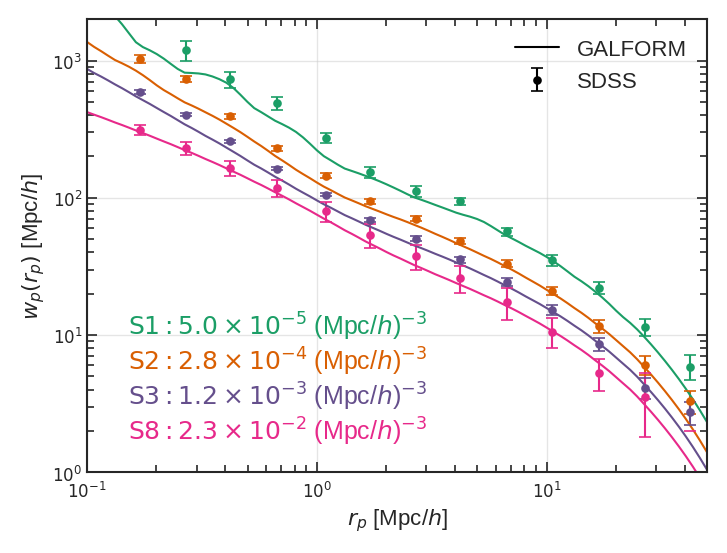

In [25]:
lines_galform = {}
lines_sdss = {}
ytext = 1e1
for sample in sample_list:
    lines_galform[sample],=plt.loglog(galform_clustering_data['rp'], galform_clustering_data['wp '+sample])
    lines_sdss[sample]=plt.errorbar(tools_pd.wp_sdss['rp'], tools_pd.wp_sdss['wp '+sample], yerr=tools_pd.wp_sdss['err '+sample], \
                                    color=lines_galform[sample].get_color(), fmt='.', mew=1.2)
    plt.text(1.5e-1, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/1.8

l1=mlines.Line2D([], [], color='k')
l2=plt.errorbar(-10, -10, yerr=2, color='k', fmt='.', mew=1.2)
leg2=plt.legend([l1, l2], ['GALFORM', 'SDSS'], loc=1, numpoints=1)
leg2.draw_frame(False)

plt.xlabel('$r_p$ [Mpc/$h$]')
plt.ylabel('$w_p(r_p)$ [Mpc/$h$]')


plt.xlim([10**-1, 50])
plt.ylim([10**0, 2*10**3])
plt.savefig(figurepath+'wprp_galform_sdss.pdf')

/cosma/local/Python/2.7.3/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


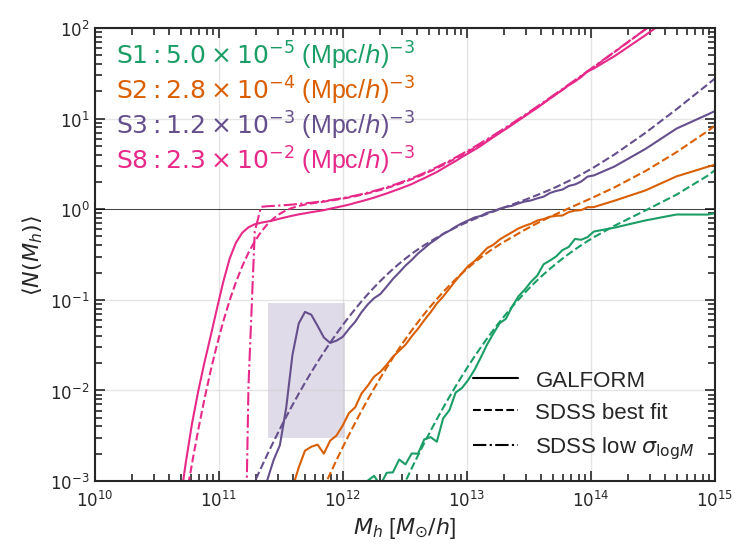

In [26]:
lines_galform = {}
lines_sdss = {}
lines_sdss_lowsigmaM = {}

ax = plt.subplot(111)

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
ytext = 4e1
for sample in sample_list:
    lines_galform[sample],=plt.loglog(mh, galform_hod[sample+' all'], label=sample_labels[sample])
    plt.loglog(mh, hod_sdss[sample], '--', color=lines_galform[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/2.44
    if (sample == 'm8'):
        lines_sdss_lowsigmaM,= plt.loglog(mh, hod_sdss_lowsigmaM[sample], '-.', color=lines_galform[sample].get_color())
     

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')
    
leg2=plt.legend([l1, l2, l3], ['GALFORM', 'SDSS best fit', r'SDSS low $\sigma_{\log M}$'], loc=4)	
leg2.draw_frame(False)
    
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])

ax.add_patch(patches.Rectangle((2.5e11, 3e-3), 8e11, .09,alpha=0.2, facecolor=list(plt.rcParams['axes.prop_cycle'])[2]['color'], edgecolor="none"))


plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')
plt.savefig(figurepath+'galform_SDSS_hod.pdf')

## Figure 5: Bias and number density integrands for Galform and SDSS

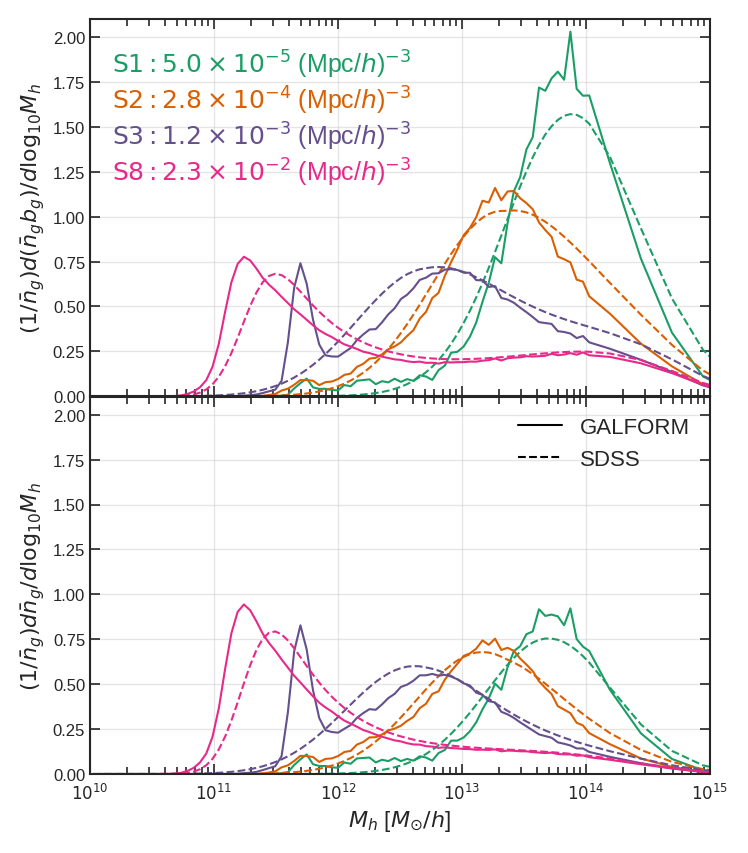

In [27]:
bw = N.diff(N.log10(halo_mass_bins))
plt.figure(figsize=(8,10))
ax1=plt.subplot(2, 1, 1)
lines_galform={}
lines_sdss={}
ytext = 1.8
for sample in sample_list:
    lines_galform[sample],=plt.semilogx(mh, halo_bias(mh)*galform_hod[sample+' all']*galform_hod['halo mass fn']/vol/nbar[sample]/bw, \
                                        label = sample_labels[sample])
    lines_sdss[sample],=plt.semilogx(mh, halo_bias(mh)*hod_sdss[sample]*dndlogM(mh)/nbar[sample], '--', \
                                     color=lines_galform[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext - 0.2

plt.ylim([0, 2.1])
plt.xlim([10**10, 10**15])
plt.ylabel(r'$(1/\bar n_g) d(\bar n_g b_g) / d\log_{10} M_h$')
ax1.set_xticklabels('')

ax2=plt.subplot(2, 1, 2)

for sample in sample_list:
    lines_galform[sample],=plt.semilogx(mh, galform_hod[sample+' all']*galform_hod['halo mass fn']/vol/nbar[sample]/bw)
    lines_sdss[sample],=plt.semilogx(mh, hod_sdss[sample]*dndlogM(mh)/nbar[sample], '--', \
                                     color=lines_galform[sample].get_color())
plt.ylim([0, 2.1])
plt.xlim([10**10, 10**15])
plt.ylabel(r'$(1/\bar n_g) d\bar n_g / d\log_{10} M_h$')
l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
leg2=plt.legend([l1, l2], [r'GALFORM', 'SDSS'], loc=1)
leg2.draw_frame(False)
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.savefig(figurepath+'bias_integrand_galform_sdss.pdf')

## Figure 6: Galform HODs split by centrals & satellites, and red & blue galaxies

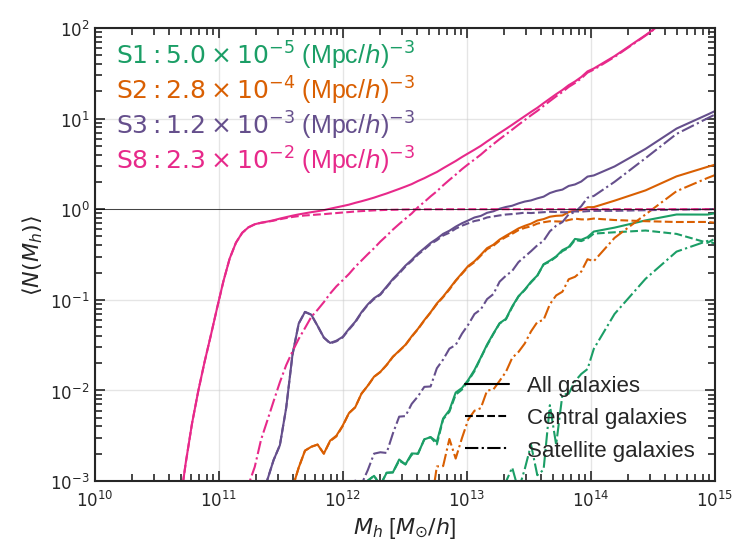

In [28]:
lines_tot = {}
lines_central = {}
lines_satellite = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, galform_hod[sample+' all'], label=sample_labels[sample])
    lines_central[sample],=plt.loglog(mh, galform_hod[sample+' central'], '--', color=lines_tot[sample].get_color())
    lines_satellite[sample],=plt.loglog(mh, galform_hod[sample +' satellite'], '-.', color=lines_tot[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/2.44

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Central galaxies', 'Satellite galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'galform_hod_centsat_magr.pdf')

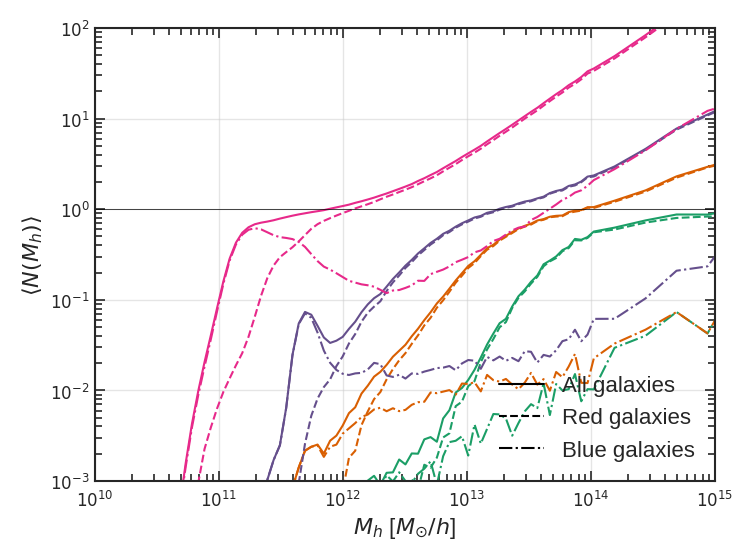

In [29]:
lines_tot = {}
lines_red = {}
lines_blue = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, galform_hod[sample + ' all'], label=sample_labels[sample])
    lines_red[sample],=plt.loglog(mh, galform_hod[sample + ' red'], '--', color=lines_tot[sample].get_color())
    lines_blue[sample],=plt.loglog(mh, galform_hod[sample+' blue'], '-.', color=lines_tot[sample].get_color())
    #plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    #ytext = ytext/2.44


plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Red galaxies', 'Blue galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'galform_hod_redblue_magr.pdf')

## Figure 7: Clustering and HODs of Galform vs SHAM

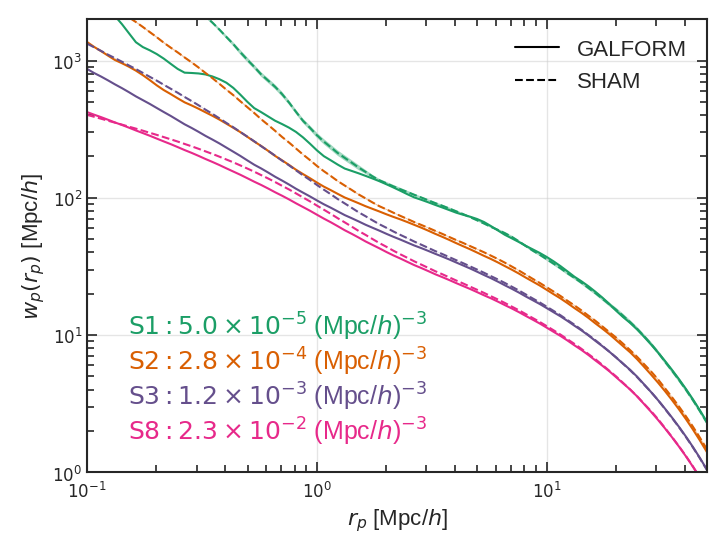

In [30]:
lines_galform={}
lines_sham={}
ytext = 1e1
for sample in sample_list:
    lines_galform[sample],=plt.loglog(rp, galform_clustering_data['wp '+sample], label=sample_labels[sample])
    lines_sham[sample],=plt.loglog(rp, sham_clustering_data.groupby('rp')['wp '+sample].mean(), '--', color=lines_galform[sample].get_color())
    plt.fill_between(rp, sham_clustering_data.groupby('rp')['wp '+sample].mean() - sham_clustering_data.groupby('rp')['wp '+sample].std()/2,sham_clustering_data.groupby('rp')['wp '+sample].mean() + sham_clustering_data.groupby('rp')['wp '+sample].std()/2, \
                     facecolor = lines_galform[sample].get_color(), alpha=0.4, interpolate=True)
    plt.text(1.5e-1, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/1.8

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')


leg2=plt.legend([l1, l2], [r'GALFORM', 'SHAM'], loc=1)
leg2.draw_frame(False)
plt.xlim([10**-1, 50])
plt.ylim([10**0, 2*10**3])

plt.xlabel('$r_p$ [Mpc/$h$]')
plt.ylabel('$w_p(r_p)$ [Mpc/$h$]')
plt.savefig(figurepath+'wprp_galform_sham_%i.pdf'%nsham)

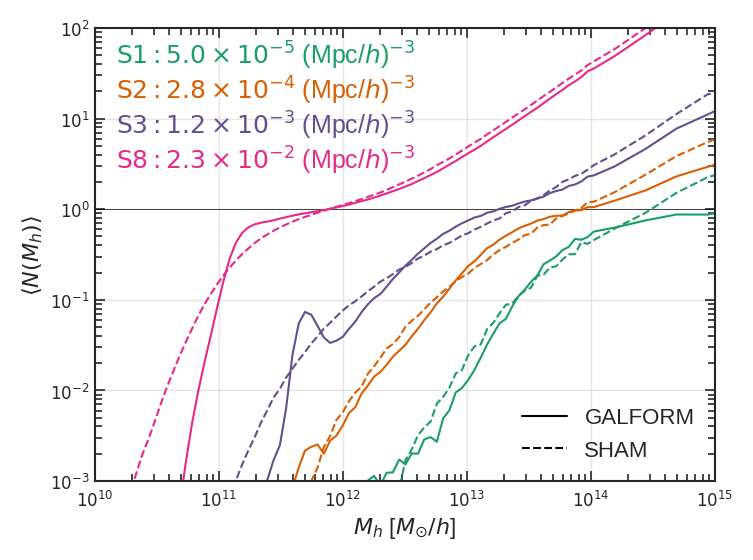

In [31]:
lines_galform = {}
lines_sham = {}

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
ytext = 4e1
for sample in sample_list:
    lines_galform[sample],=plt.loglog(mh, galform_hod[sample + ' all'], label=sample_labels[sample])
    lines_sham[sample],=plt.loglog(mh, sham_hod[sample + ' all'], '--', color=lines_galform[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/2.44  

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
    
leg2=plt.legend([l1, l2, l3], ['GALFORM', 'SHAM'], loc=4)
leg2.draw_frame(False)
    
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])


plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')
plt.savefig(figurepath+'galform_sham_hod.pdf')

## Figure 8: Bias and number density integrands for Galform and SHAM

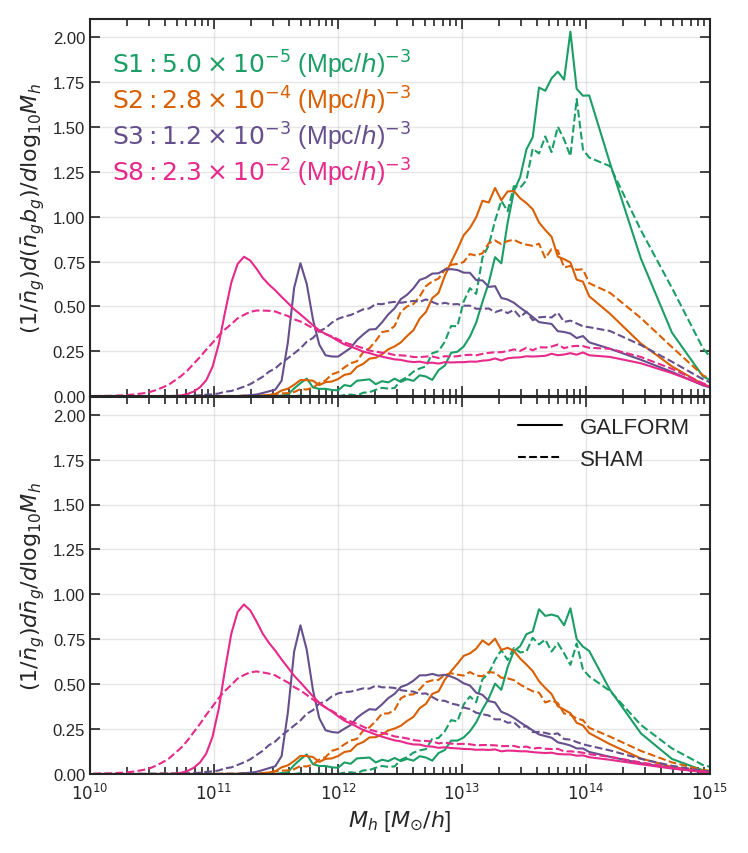

In [32]:
plt.figure(figsize=(8,10))
ax1=plt.subplot(2, 1, 1)
lines_galform={}
lines_sham={}
ytext=1.8
for sample in sample_list:
    lines_galform[sample],=plt.semilogx(mh, halo_bias(mh)*galform_hod[sample+' all']*galform_hod['halo mass fn']/vol/nbar[sample]/bw, \
                                        label = sample_labels[sample])
    lines_sham[sample],=plt.semilogx(mh, halo_bias(mh)*sham_hod[sample+' all']*sham_hod['halo mass fn']/vol/nbar[sample]/bw, '--', \
                                     color=lines_galform[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext - 0.2


plt.ylim([0, 2.1])
plt.xlim([10**10, 10**15])
plt.ylabel(r'$(1/\bar n_g) d(\bar n_g b_g) / d\log_{10} M_h$')
ax1.set_xticklabels('')

ax2=plt.subplot(2, 1, 2)

for sample in sample_list:
    lines_galform[sample],=plt.semilogx(mh, galform_hod[sample+' all']*galform_hod['halo mass fn']/vol/nbar[sample]/bw)
    lines_sham[sample],=plt.semilogx(mh, sham_hod[sample+' all']*sham_hod['halo mass fn']/vol/nbar[sample]/bw, '--', \
                                     color=lines_galform[sample].get_color())
plt.ylim([0, 2.1])
plt.xlim([10**10, 10**15])
plt.ylabel(r'$(1/\bar n_g) d\bar n_g / d\log_{10} M_h$')
l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
leg2=plt.legend([l1, l2], [r'GALFORM', 'SHAM'], loc=1)
leg2.draw_frame(False)
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.savefig(figurepath+'bias_integrand_galform_SHAM.pdf')

## Figure 9: Bestfit HOD models for bootstrapped Galform and SHAM catalogues

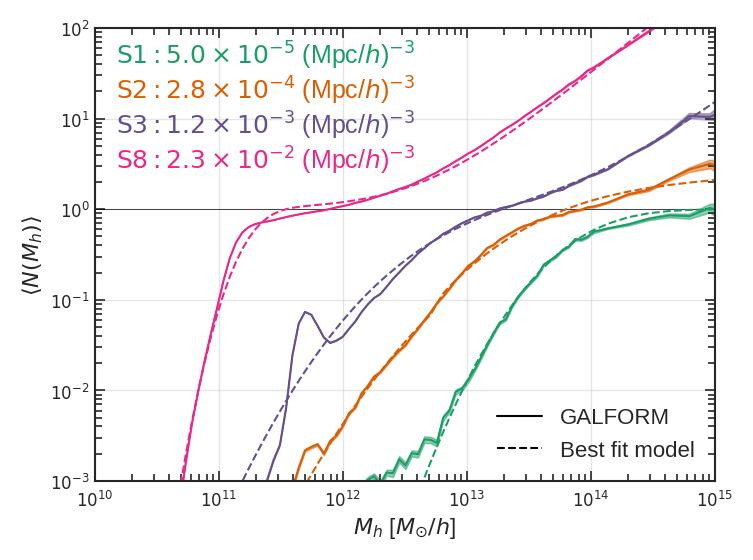

In [44]:
lines_galform = {}

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
ytext = 4e1

for sample in sample_list:
    lines_galform[sample],=plt.loglog(galform_hod_boot['mh'].unique(), galform_hod_boot.groupby('mh')[sample].mean(), label=sample_labels[sample])
    plt.fill_between(galform_hod_boot['mh'].unique(), galform_hod_boot.groupby('mh')[sample].mean()-galform_hod_boot.groupby('mh')[sample].std()/2, \
                     galform_hod_boot.groupby('mh')[sample].mean()+galform_hod_boot.groupby('mh')[sample].std()/2, alpha=0.5, \
                     color=lines_galform[sample].get_color())
    plt.loglog(galform_hod_bestfit['mh'], galform_hod_bestfit[sample], '--', color=lines_galform[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/2.44

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
    
leg2=plt.legend([l1, l2], ['GALFORM', 'Best fit model'], loc=4)
leg2.draw_frame(False)
    
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])


plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')
plt.savefig(figurepath+'galform_bestfit_hod.pdf')

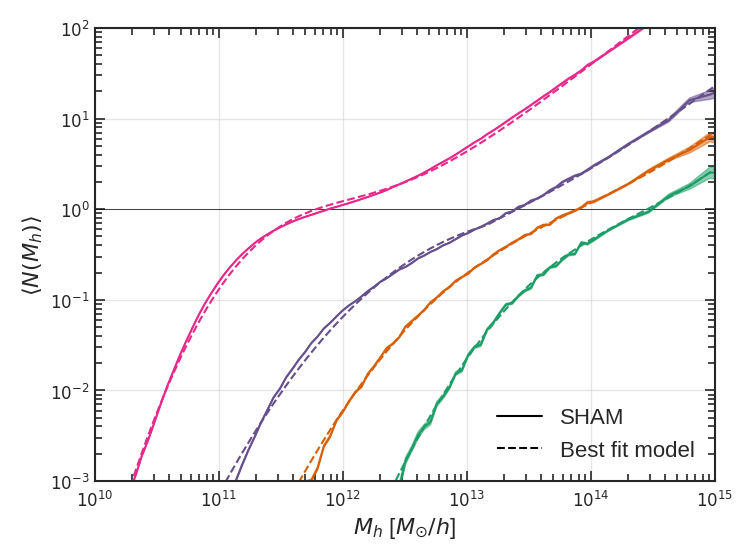

In [45]:
lines_sham = {}

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
ytext = 4e1

for sample in sample_list:
    lines_sham[sample],=plt.loglog(sham_hod_boot['mh'].unique(), sham_hod_boot.groupby('mh')[sample].mean(), label=sample_labels[sample])
    plt.fill_between(sham_hod_boot['mh'].unique(), sham_hod_boot.groupby('mh')[sample].mean()-sham_hod_boot.groupby('mh')[sample].std()/2, \
                     sham_hod_boot.groupby('mh')[sample].mean()+sham_hod_boot.groupby('mh')[sample].std()/2, alpha=0.5, \
                     color=lines_sham[sample].get_color())
    plt.loglog(sham_hod_bestfit['mh'], sham_hod_bestfit[sample], '--', color=lines_sham[sample].get_color())
    #plt.text(1.5e10, ytext, sample_labels[sample], color=lines_sham[sample].get_color(), fontsize=18)
    #ytext = ytext/2.44
    
    
l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
    
leg2=plt.legend([l1, l2], ['SHAM', 'Best fit model'], loc=4)
leg2.draw_frame(False)
    
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])


plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')
plt.savefig(figurepath+'SHAM_bestfit_hod.pdf')

## Figure 10: L-Galaxies HODs split into centrals & satellites, red & blue

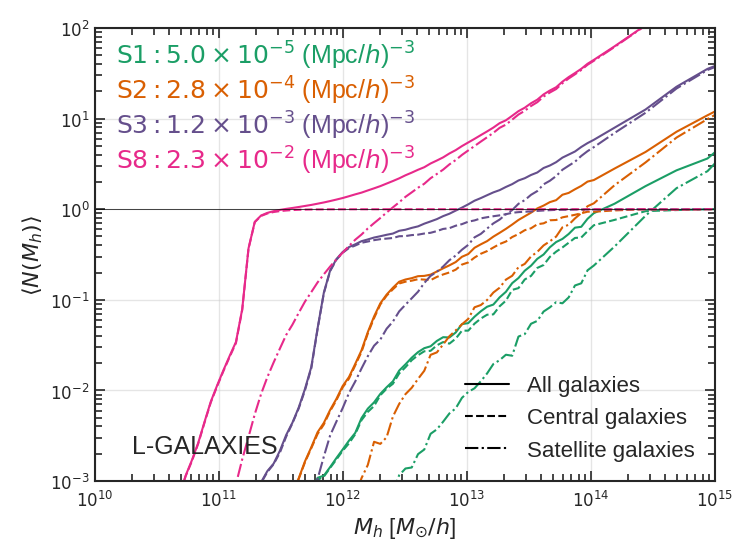

In [52]:
lines_tot = {}
lines_central = {}
lines_satellite = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, lgals_hod[sample+' all'], label=sample_labels[sample])
    lines_central[sample],=plt.loglog(mh, lgals_hod[sample+' central'], '--', color=lines_tot[sample].get_color())
    lines_satellite[sample],=plt.loglog(mh, lgals_hod[sample +' satellite'], '-.', color=lines_tot[sample].get_color())
    plt.text(1.5e10, ytext, sample_labels[sample], color=lines_tot[sample].get_color(), fontsize=18)
    ytext = ytext/2.44

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')
plt.text(2*10**10, 2*10**-3, 'L-GALAXIES', fontsize=18)

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Central galaxies', 'Satellite galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'lgals_hod_centsat.pdf')

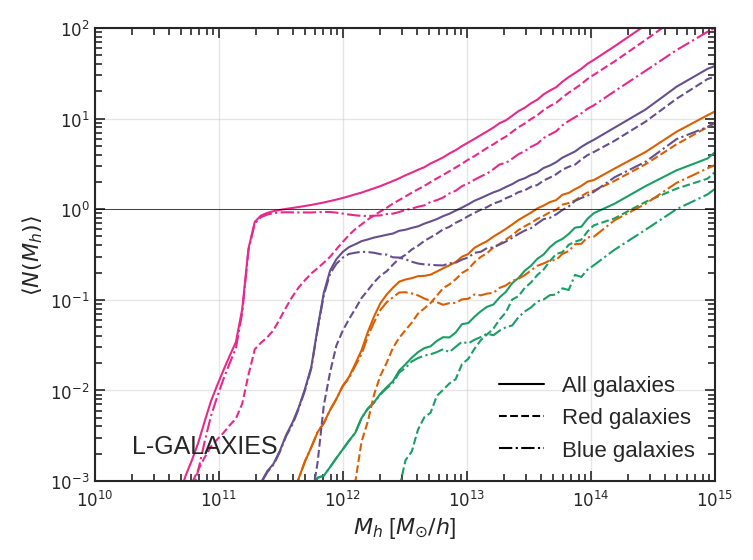

In [53]:
lines_tot = {}
lines_red = {}
lines_blue = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, lgals_hod[sample+' all'], label=sample_labels[sample])
    lines_red[sample],=plt.loglog(mh, lgals_hod[sample+' red'], '--', color=lines_tot[sample].get_color())
    lines_blue[sample],=plt.loglog(mh, lgals_hod[sample +' blue'], '-.', color=lines_tot[sample].get_color())
    #plt.text(1.5e10, ytext, sample_labels[sample], color=lines_tot[sample].get_color(), fontsize=18)
    #ytext = ytext/2.44

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')
plt.text(2*10**10, 2*10**-3, 'L-GALAXIES', fontsize=18)

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Red galaxies', 'Blue galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'lgals_hod_redblue.pdf')

## Figure 11: Galform and L-Galaxies HODs in stellar mass samples

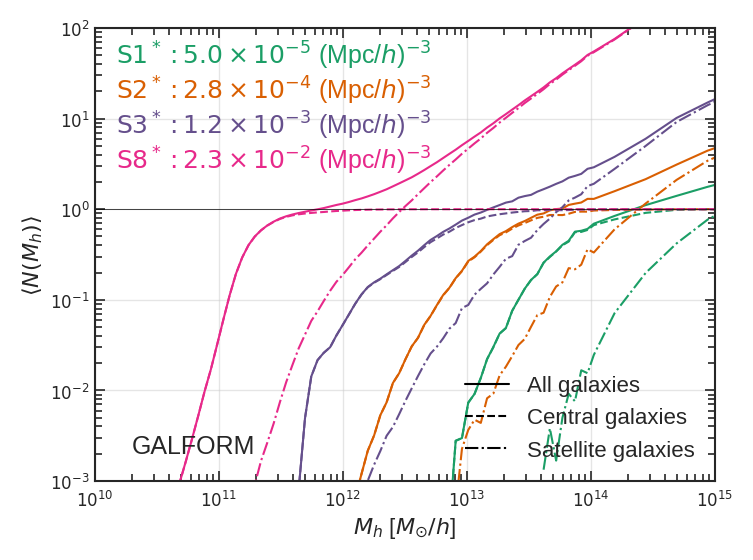

In [61]:
lines_tot = {}
lines_central = {}
lines_satellite = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, galform_hod[sample+' all mstar'], label=sample_labels[sample])
    lines_central[sample],=plt.loglog(mh, galform_hod[sample+' central mstar'], '--', color=lines_tot[sample].get_color())
    lines_satellite[sample],=plt.loglog(mh, galform_hod[sample +' satellite mstar'], '-.', color=lines_tot[sample].get_color())
    plt.text(1.5e10, ytext, mstar_sample_labels[sample], color=lines_tot[sample].get_color(), fontsize=18)
    ytext = ytext/2.44

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')
plt.text(2*10**10, 2*10**-3, 'GALFORM', fontsize=18)

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Central galaxies', 'Satellite galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'galform_hod_centsat_mstar.pdf')

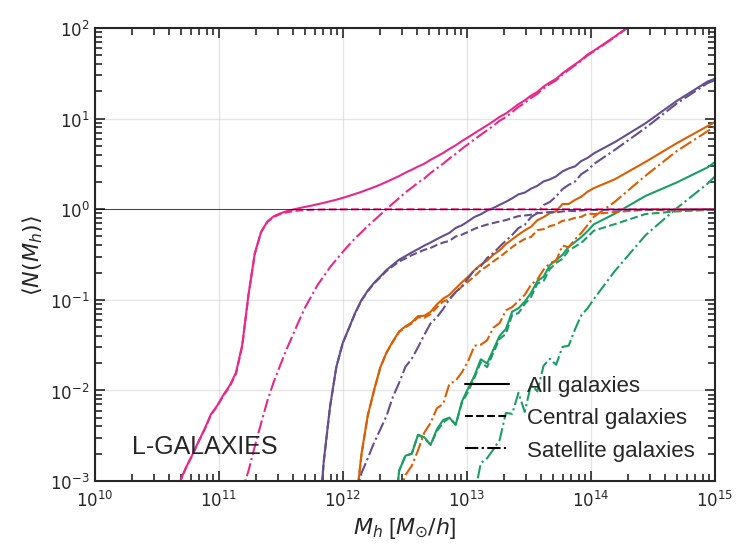

In [55]:
lines_tot = {}
lines_central = {}
lines_satellite = {}
ytext=4e1
for sample in sample_list:
    lines_tot[sample],=plt.loglog(mh, lgals_hod[sample+' all mstar'], label=sample_labels[sample])
    lines_central[sample],=plt.loglog(mh, lgals_hod[sample+' central mstar'], '--', color=lines_tot[sample].get_color())
    lines_satellite[sample],=plt.loglog(mh, lgals_hod[sample +' satellite mstar'], '-.', color=lines_tot[sample].get_color())
    #plt.text(1.5e10, ytext, sample_labels[sample], color=lines_tot[sample].get_color(), fontsize=18)
    #ytext = ytext/2.44

plt.plot([10**10, 10**15], [1, 1], 'k', lw=0.5)
plt.xlim([10**10, 10**15])
plt.ylim([10**-3, 10**2])	
plt.xlabel(r'$M_h$ [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N(M_h) \rangle$')

l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
l3=mlines.Line2D([], [], color='k', linestyle='-.')
plt.text(2*10**10, 2*10**-3, 'L-GALAXIES', fontsize=18)

leg2=plt.legend([l1, l2, l3], ['All galaxies', 'Central galaxies', 'Satellite galaxies'], loc=4)
leg2.draw_frame(False)
plt.savefig(figurepath+'lgals_hod_centsat_mstar.pdf')

## Figure 12: VPFs of Galform samples in real and redshift space

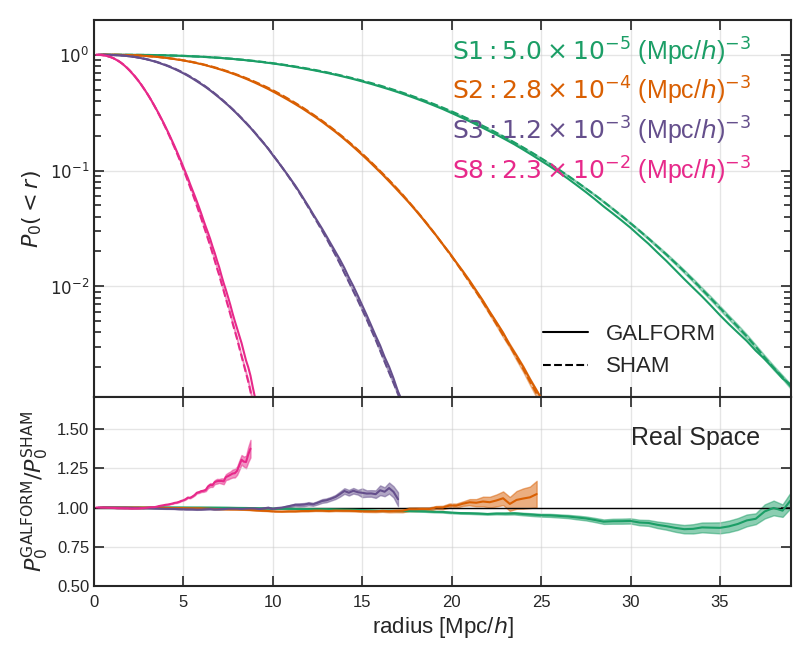

In [56]:
plt.figure(figsize=(9, 7.5))
ax1=plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

lines_gal={}
lines_SHAM={}
ytext = 0.9
for sample in sample_list:
    lines_gal[sample],=plt.semilogy(vpf_galform['r '+sample], vpf_galform['vpf real '+sample], label=sample_labels[sample])
    lines_SHAM[sample],= plt.semilogy(vpf_galform['r '+sample], vpf_sham.groupby('r '+sample)['vpf real '+sample].mean(), '--', color=lines_gal[sample].get_color())
    plt.fill_between(vpf_galform['r '+sample], vpf_sham.groupby('r '+sample)['vpf real '+sample].mean()-vpf_sham.groupby('r '+sample)['vpf real '+sample].std()/2, \
                     vpf_sham.groupby('r '+sample)['vpf real '+sample].mean()+vpf_sham.groupby('r '+sample)['vpf real '+sample].std()/2, \
                     color=lines_gal[sample].get_color(), alpha=0.4, interpolate=True)
    plt.text(20, ytext, sample_labels[sample], color=lines_gal[sample].get_color(), fontsize=18)
    ytext = ytext/2.2



l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
leg2=plt.legend([l1, l2], ['GALFORM', 'SHAM'], loc=4, bbox_to_anchor=(0.92, 0))
leg2.draw_frame(False)
plt.xlim([0, 39])
plt.ylim([1.1*10**-3, 2])
plt.ylabel('$P_0(<r)$')
ax1.set_xticklabels('')

ax2=plt.subplot2grid((3, 3), (2, 0), colspan=3, rowspan=1)
plt.plot([0, 40], [1.0, 1.0], 'k', lw=1.0)
lines_ratio={}
YLIMIT = 10**-3

for sample in sample_list:
    subset = ((vpf_galform['vpf real '+sample].values > YLIMIT) & (vpf_sham.groupby('r '+sample)['vpf real '+sample].mean().values > YLIMIT))

    vpf_ratio_mean = vpf_sham.groupby('r '+sample)['ratio real '+sample].mean().values
    vpf_ratio_std = vpf_sham.groupby('r '+sample)['ratio real '+sample].std().values
    
    lines_ratio[sample],=plt.plot(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset])
    plt.fill_between(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset]-vpf_ratio_std[subset]/2, \
                     vpf_ratio_mean[subset]+vpf_ratio_std[subset]/2, \
                     color=lines_ratio[sample].get_color(), alpha=0.5, interpolate=True)

plt.text(30, 1.4, 'Real Space', fontsize=18)
plt.xlim([0, 39])
plt.ylim([0.5, 1.7])
plt.xlabel('radius [Mpc/$h$]')
plt.ylabel(r'$P_0^{\rm{GALFORM}}/P_0^{\rm{SHAM}}$')
plt.savefig(figurepath+'vpf_galform_sham_%i.pdf'%nsham, bbox_inches='tight')

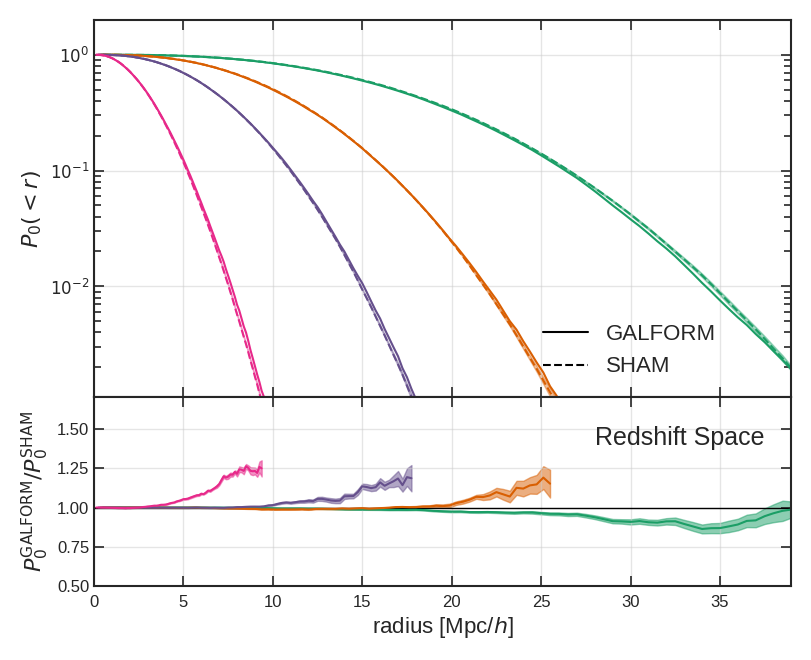

In [57]:
plt.figure(figsize=(9, 7.5))
ax1=plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

lines_gal={}
lines_SHAM={}
for sample in sample_list:
    lines_gal[sample],=plt.semilogy(vpf_galform['r '+sample], vpf_galform['vpf redshift '+sample], label=sample_labels[sample])
    lines_SHAM[sample],= plt.semilogy(vpf_galform['r '+sample], vpf_sham.groupby('r '+sample)['vpf redshift '+sample].mean(), '--', color=lines_gal[sample].get_color())
    plt.fill_between(vpf_galform['r '+sample], vpf_sham.groupby('r '+sample)['vpf redshift '+sample].mean()-vpf_sham.groupby('r '+sample)['vpf redshift '+sample].std()/2, \
                     vpf_sham.groupby('r '+sample)['vpf redshift '+sample].mean()+vpf_sham.groupby('r '+sample)['vpf redshift '+sample].std()/2, \
                     color=lines_gal[sample].get_color(), alpha=0.4, interpolate=True)



l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
leg2=plt.legend([l1, l2], ['GALFORM', 'SHAM'], loc=4, bbox_to_anchor=(0.92, 0))
leg2.draw_frame(False)
plt.xlim([0, 39])
plt.ylim([1.1*10**-3, 2])
plt.ylabel('$P_0(<r)$')
ax1.set_xticklabels('')

ax2=plt.subplot2grid((3, 3), (2, 0), colspan=3, rowspan=1)
plt.plot([0, 40], [1.0, 1.0], 'k', lw=1.0)
lines_ratio={}
YLIMIT = 10**-3

for sample in sample_list:
    subset = ((vpf_galform['vpf redshift '+sample].values > YLIMIT) & (vpf_sham.groupby('r '+sample)['vpf redshift '+sample].mean().values > YLIMIT))

    vpf_ratio_mean = vpf_sham.groupby('r '+sample)['ratio redshift '+sample].mean().values
    vpf_ratio_std = vpf_sham.groupby('r '+sample)['ratio redshift '+sample].std().values
    
    lines_ratio[sample],=plt.plot(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset])
    plt.fill_between(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset]-vpf_ratio_std[subset]/2, \
                     vpf_ratio_mean[subset]+vpf_ratio_std[subset]/2, \
                     color=lines_ratio[sample].get_color(), alpha=0.5, interpolate=True)

plt.text(28, 1.4, 'Redshift Space', fontsize=18)
plt.xlim([0, 39])
plt.ylim([0.5, 1.7])
plt.xlabel('radius [Mpc/$h$]')
plt.ylabel(r'$P_0^{\rm{GALFORM}}/P_0^{\rm{SHAM}}$')
plt.savefig(figurepath+'vpf_galform_sham_%i_rs.pdf'%nsham, bbox_inches='tight')

## Figure 13: Clustering and VPFs in shuffled Galform and SHAM samples

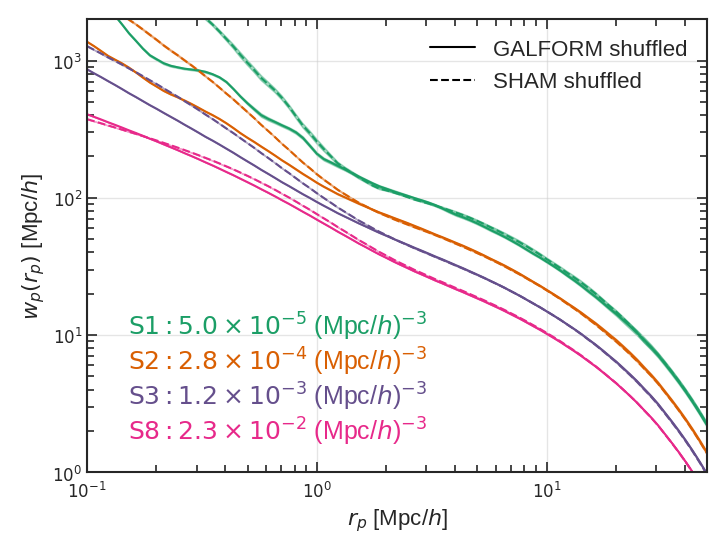

In [289]:
lines_galform={}
lines_sham={}
ytext = 1e1
for sample in sample_list:
    r = galform_shuffled_wp['r'].unique()
    lines_galform[sample],=plt.loglog(r, galform_shuffled_wp.groupby('r')['wp '+sample].mean(), label=sample_labels[sample])
    plt.fill_between(r, galform_shuffled_wp.groupby('r')['wp '+sample].mean() - galform_shuffled_wp.groupby('r')['wp '+sample].std()/2,\
                     galform_shuffled_wp.groupby('r')['wp '+sample].mean()+galform_shuffled_wp.groupby('r')['wp '+sample].std()/2, \
                     color=lines_galform[sample].get_color(), alpha=0.4, interpolate=True)
    r = sham_shuffled_wp['r'].unique()
    lines_sham[sample], =plt.loglog(r, sham_shuffled_wp.groupby('r')['wp '+sample].mean(), '--', color=lines_galform[sample].get_color())
    plt.fill_between(rps, sham_shuffled_wp.groupby('r')['wp '+sample].mean()-sham_shuffled_wp.groupby('r')['wp '+sample].std()/2, \
                     sham_shuffled_wp.groupby('r')['wp '+sample].mean()+sham_shuffled_wp.groupby('r')['wp '+sample].std()/2, \
                     color=lines_galform[sample].get_color(), alpha=0.4, interpolate=True)
    plt.text(1.5e-1, ytext, sample_labels[sample], color=lines_galform[sample].get_color(), fontsize=18)
    ytext = ytext/1.8



l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')

leg1=plt.legend([l1, l2], [r'GALFORM shuffled', 'SHAM shuffled'], loc=1)
leg1.draw_frame(False)
leg2.draw_frame(False)
plt.xlim([10**-1, 50])
plt.ylim([10**0, 2*10**3])

plt.xlabel('$r_p$ [Mpc/$h$]')
plt.ylabel('$w_p(r_p)$ [Mpc/$h$]')

plt.savefig(figurepath+'wprp_galform_%i_sham_%i_shuffle.pdf'%(nshuffle_galform, nsham), bbox_inches='tight')

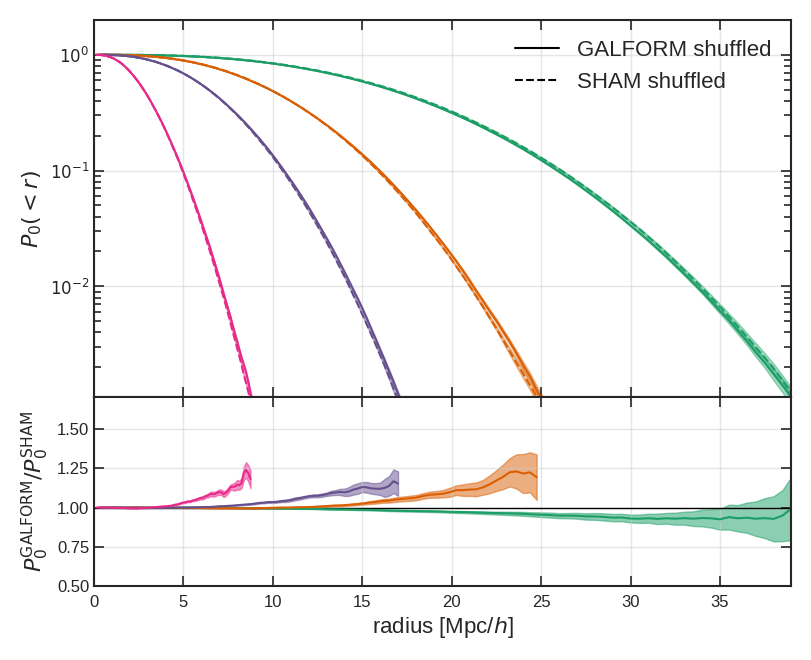

In [83]:
#galform_vpf_shuffled = pd.DataFrame()
#sham_vpf_shuffled = pd.DataFrame()
#ratio_vpf_shuffled = pd.DataFrame()

plt.figure(figsize=(9, 7.5))
ax1=plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

lines_gal={}
lines_SHAM={}
for sample in sample_list:
    r = galform_vpf_shuffled['r '+sample].unique()
    lines_gal[sample],=plt.semilogy(r, galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean(), label=sample_labels[sample])
    lines_SHAM[sample],= plt.semilogy(r, sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean(), '--', color=lines_gal[sample].get_color())
    plt.fill_between(r, galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean()-galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].std()/2, \
                     galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean()+galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].std()/2, \
                     color=lines_gal[sample].get_color(), alpha=0.4, interpolate=True)
    plt.fill_between(r, sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean()-sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].std()/2, \
                     sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean()+sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].std()/2, \
                     color=lines_gal[sample].get_color(), alpha=0.4, interpolate=True)


l1=mlines.Line2D([], [], color='k')
l2=mlines.Line2D([], [], color='k', linestyle='--')
leg2=plt.legend([l1, l2], ['GALFORM shuffled', 'SHAM shuffled'], loc=1)
leg2.draw_frame(False)
plt.xlim([0, 39])
plt.ylim([1.1*10**-3, 2])
plt.ylabel('$P_0(<r)$')
ax1.set_xticklabels('')

ax2=plt.subplot2grid((3, 3), (2, 0), colspan=3, rowspan=1)
plt.plot([0, 40], [1.0, 1.0], 'k', lw=1.0)
lines_ratio={}
YLIMIT = 10**-3

for sample in sample_list:
    subset = ((galform_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean().values > YLIMIT) & (sham_vpf_shuffled.groupby('r '+sample)['vpf '+sample].mean().values > YLIMIT))

    vpf_ratio_mean = ratio_vpf_shuffled.groupby('r '+sample)['ratio '+sample].mean().values
    vpf_ratio_std = ratio_vpf_shuffled.groupby('r '+sample)['ratio '+sample].std().values
    
    lines_ratio[sample],=plt.plot(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset])
    plt.fill_between(vpf_galform.loc[subset, 'r '+sample], vpf_ratio_mean[subset]-vpf_ratio_std[subset]/2, \
                     vpf_ratio_mean[subset]+vpf_ratio_std[subset]/2, \
                     color=lines_ratio[sample].get_color(), alpha=0.5, interpolate=True)

plt.xlim([0, 39])
plt.ylim([0.5, 1.7])
plt.xlabel('radius [Mpc/$h$]')
plt.ylabel(r'$P_0^{\rm{GALFORM}}/P_0^{\rm{SHAM}}$')
plt.savefig(figurepath+'vpf_galform_%i_sham_shuffle_%i.pdf'%(nshuffle_galform, nsham), bbox_inches='tight')